# Lecture : Graph-based Visualization

## Lab 03 : Locally Linear Embedding (LLE)

### Xavier Bresson  


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML2023_codes/codes/06_Visualization'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Load libraries
import numpy as np
import scipy.io
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import sys; sys.path.insert(0, 'lib/')
import scipy.sparse.linalg
# import scipy.ndimage
from lib.utils import compute_pca, construct_knn_graph
import warnings; warnings.filterwarnings("ignore")
import torch


# LLE for Swiss Roll

In [2]:
# Swiss roll data
mat = scipy.io.loadmat('datasets/swiss_roll.mat')
X = mat['X']
Xref = X
n = X.shape[0]
d = X.shape[1]
Cgt = C = mat['Cgt'].squeeze()
print(n,d)


2048 3


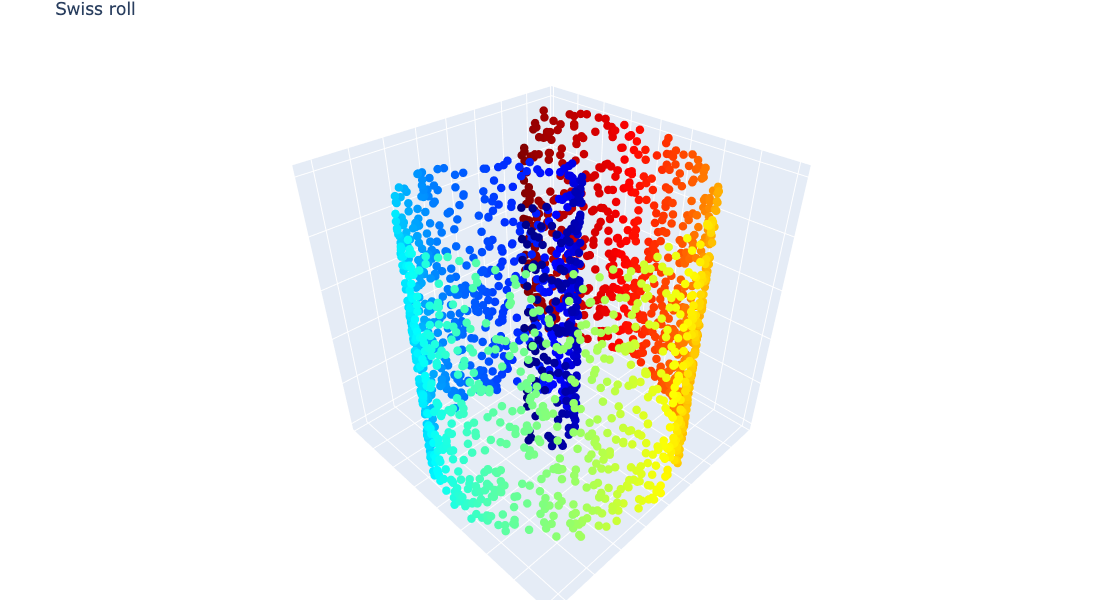

In [3]:
Xvis, Yvis, Zvis = X[:,0], X[:,1], X[:,2]
Ccolor = ['rgb('+str(c[0]*255)+', '+str(c[1]*255)+', '+str(c[2]*255)+')' for c in Cgt]

# 3D Visualization
import plotly.graph_objects as go
data = go.Scatter3d(x=Xvis, y=Yvis, z=Zvis, mode='markers', marker=dict(size=5, color=Ccolor, colorscale='jet', opacity=1)) # data as points
# data = go.Scatter3d(x=Xvis, y=Yvis, z=Zvis, mode='markers', marker=dict(size=1, color=C, colorscale='jet', opacity=1, showscale=True)) # w/ colobar 
fig = go.Figure(data=[data]) 
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=0)) # tight layout but t=25 required for showing title 
fig.update_layout(autosize=False, width=600, height=600, title_text="Swiss roll") # figure size and title
# fig.update_layout(scene = dict(xaxis = dict(visible=False), yaxis = dict(visible=False), zaxis = dict(visible=False))) # no grid, no axis 
# fig.update_layout(scene = dict(xaxis_title = ' ', yaxis_title = ' ', zaxis_title = ' ')) # no axis name 
fig.update_layout(scene = dict(zaxis = dict(showgrid = True, showticklabels = False), zaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(yaxis = dict(showgrid = True, showticklabels = False), yaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(xaxis = dict(showgrid = True, showticklabels = False), xaxis_title = ' ') ) # no range values, no axis name, grid on
fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.show()


In [4]:
# Run LLE
X = Xref
X = X - np.mean(X,axis=0) # zero-centered data

# Step 1: Compute k-NN
kNN = 20
WkNN = construct_knn_graph(X,kNN,'euclidean').todense()

# Step 2: Compute locally linear patches
start = time.time()
W = np.zeros([n,n])
for i in range(n): 
    # Find neighbors of data i
    idx_kNN = np.where(WkNN[i,:]>0.0)[1]
    K = len(idx_kNN)
    if K>kNN:
        K = kNN 
        idx_kNN = idx_kNN[:K]
    XkNN = X[idx_kNN,:]
    Ones = np.ones([K,1])
    C = (X[i,:][:,None].dot(Ones.T) - XkNN.T).T    
    C = C.dot(C.T)
    # if K (nb nearest neighbors) > d (data dimensionality) then regularization is required
    C = C + 1e-1* np.eye(K)#* trace(C)
    t,_ = scipy.sparse.linalg.cg(C, Ones)
    t = t/ (Ones.T.dot(t))
    W[i,idx_kNN] = t
print('time(min) step 2 :',(time.time()-start)/60)


Convert from numpy to pytorch
k-NN graph construction with euclidean distance
n, batch_size, num_batch, kNN, device: 2048 5000 1 20 cpu
batch idx: 1 / 1  time(sec): 0.08594083786010742
Computational time(sec) for k-NN graph: 0.08969902992248535
time(min) step 2 : 0.0025678316752115885


In [5]:
# Step 3: Compute low-dim embedding coordinates
start = time.time()
M = ( np.eye(n) - W.T ).dot( np.eye(n) - W ) 
# EVD
lamb, U = np.linalg.eig(M)
def sortEVD(lamb, U):
    idx = lamb.argsort()
    return lamb[idx], U[:,idx]
lamb, U = sortEVD(lamb, U)
print(lamb[:4])
Xvis = U[:,1]
Yvis = U[:,2]
Zvis = U[:,3]
print('time(min) step 3 :',(time.time()-start)/60)


[-1.20803728e-15  8.39787336e-09  1.59737028e-07  5.75272717e-07]
time(min) step 3 : 0.11514817873636882


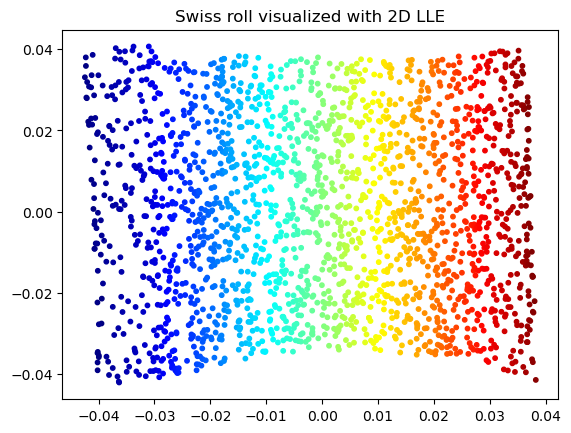

In [6]:
# 2D Plot
plt.figure(2)
size_vertex_plot = 10
plt.scatter(Xvis, Yvis, s=size_vertex_plot*np.ones(n), c=Cgt, color=pyplot.jet())
plt.title('Swiss roll visualized with 2D LLE') 
plt.show()


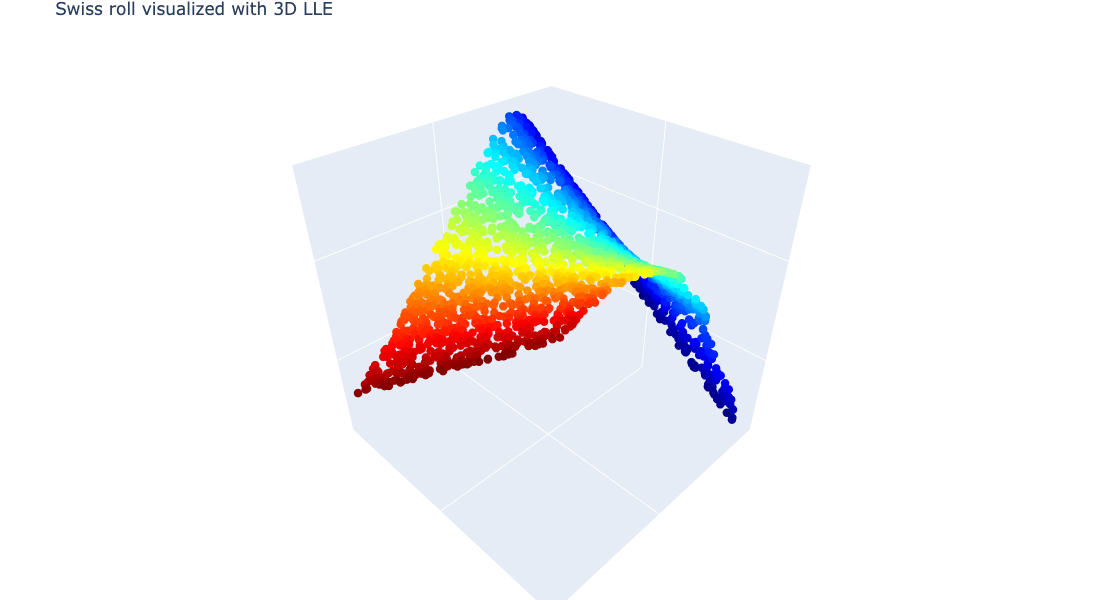

In [7]:
# 3D Visualization
import plotly.graph_objects as go
data = go.Scatter3d(x=Xvis, y=Yvis, z=Zvis, mode='markers', marker=dict(size=5, color=Ccolor, colorscale='jet', opacity=1)) # data as points
# data = go.Scatter3d(x=Xvis, y=Yvis, z=Zvis, mode='markers', marker=dict(size=1, color=C, colorscale='jet', opacity=1, showscale=True)) # w/ colobar 
fig = go.Figure(data=[data]) 
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=0)) # tight layout but t=25 required for showing title 
fig.update_layout(autosize=False, width=600, height=600, title_text="Swiss roll visualized with 3D LLE") # figure size and title
# fig.update_layout(scene = dict(xaxis = dict(visible=False), yaxis = dict(visible=False), zaxis = dict(visible=False))) # no grid, no axis 
# fig.update_layout(scene = dict(xaxis_title = ' ', yaxis_title = ' ', zaxis_title = ' ')) # no axis name 
fig.update_layout(scene = dict(zaxis = dict(showgrid = True, showticklabels = False), zaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(yaxis = dict(showgrid = True, showticklabels = False), yaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(xaxis = dict(showgrid = True, showticklabels = False), xaxis_title = ' ') ) # no range values, no axis name, grid on
fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.show()


# LLE for MNIST

In [11]:
# MNIST dataset
mat = scipy.io.loadmat('datasets/MNIST_data.mat')
X = Xref = mat['X']
n = X.shape[0]
d = X.shape[1]
C = Cgt = mat['C'].squeeze()
print(n,d)

# Select a subset of classes
# classes = [4,9]; num_sample_per_class = 1000 # non-linear classes
# classes = [0,2]; num_sample_per_class = 1000 # non-linear classes
classes = [0,1,2,3,4,5,6,7,8,9]; num_sample_per_class = 500 # 250 all classes
X = torch.Tensor(X)
C = torch.Tensor(C)
print(X.size(), C.size())
newX = []
newC = []
for idx_new_class, idx_class in enumerate(classes):
    idx_data = (C==idx_class).nonzero().squeeze()
    #print('idx_data',idx_data.size())
    idx_data = idx_data[:num_sample_per_class]
    newX.append(X[idx_data,:])
    #newC.append(C[idx_data])
    newC.append(idx_new_class* torch.ones(idx_data.size(0)))
newX = torch.cat(newX)
newC = torch.cat(newC)
print(newX.size(), newC.size())
X = Xref = newX.numpy()
C = Cgt = newC.numpy()


60000 784
torch.Size([60000, 784]) torch.Size([60000])
torch.Size([5000, 784]) torch.Size([5000])


Convert from numpy to pytorch
k-NN graph construction with euclidean distance
n, batch_size, num_batch, kNN, device: 5000 5000 1 20 cpu
batch idx: 1 / 1  time(sec): 0.6629760265350342
Computational time(sec) for k-NN graph: 0.6743872165679932
time(min) step 2 : 0.024235947926839193
[0.00000000e+00 3.49291451e-05 5.99621463e-05 1.67889105e-04]
time(min) step 3 : 1.3599955360094707


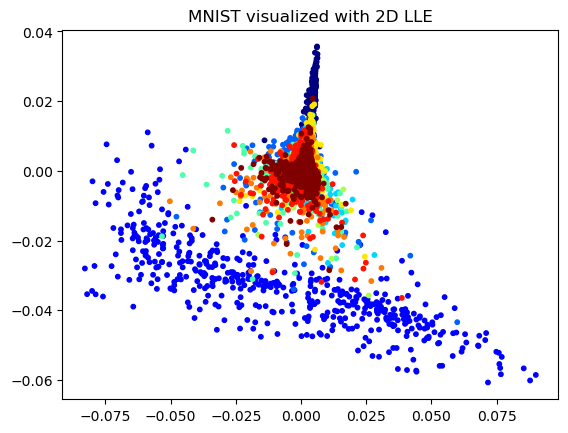

In [12]:
# Run LLE
X = Xref
X = X - np.mean(X,axis=0) # zero-centered data

# Step 1: Compute k-NN
kNN = 20
WkNN = construct_knn_graph(X,kNN,'euclidean').todense()

# Step 2: Compute locally linear patches
start = time.time()
n = X.shape[0]
W = np.zeros([n,n])
for i in range(n): 
    # Find neighbors of data i
    idx_kNN = np.where(WkNN[i,:]>0.0)[1]
    K = len(idx_kNN)
    if K>kNN:
        K = kNN 
        idx_kNN = idx_kNN[:K]
    XkNN = X[idx_kNN,:]
    Ones = np.ones([K,1])
    C = (X[i,:][:,None].dot(Ones.T) - XkNN.T).T    
    C = C.dot(C.T)
    # if K (nb nearest neighbors) > d (data dimensionality) then regularization is required
    C = C + 1e-1* np.eye(K)#* trace(C)
    t,_ = scipy.sparse.linalg.cg(C, Ones)
    t = t/ (Ones.T.dot(t))
    W[i,idx_kNN] = t
print('time(min) step 2 :',(time.time()-start)/60)

# Step 3: Compute low-dim embedding coordinates
start = time.time()
M = ( np.eye(n) - W.T ).dot( np.eye(n) - W ) 
# EVD
lamb, U = np.linalg.eig(M)
def sortEVD(lamb, U):
    idx = lamb.argsort()
    return lamb[idx], U[:,idx]
lamb, U = sortEVD(lamb, U)
print(lamb[:4])
Xvis = U[:,1]
Yvis = U[:,2]
Zvis = U[:,3]
print('time(min) step 3 :',(time.time()-start)/60)

# 2D Plot
plt.figure(2)
size_vertex_plot = 10
plt.scatter(Xvis, Yvis, s=size_vertex_plot*np.ones(n), c=Cgt, color=pyplot.jet())
plt.title('MNIST visualized with 2D LLE') 
plt.show()


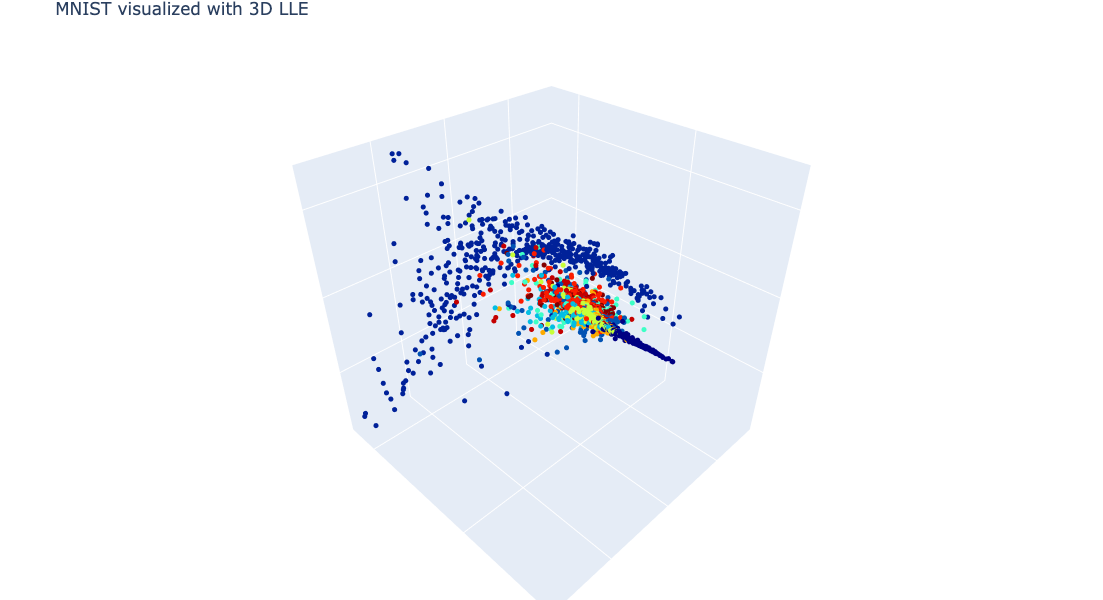

In [13]:
# 3D Visualization
import plotly.graph_objects as go
data = go.Scatter3d(x=Xvis, y=Yvis, z=Zvis, mode='markers', marker=dict(size=3, color=Cgt, colorscale='jet', opacity=1)) # data as points
# data = go.Scatter3d(x=Xvis, y=Yvis, z=Zvis, mode='markers', marker=dict(size=1, color=C, colorscale='jet', opacity=1, showscale=True)) # w/ colobar 
fig = go.Figure(data=[data]) 
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=0)) # tight layout but t=25 required for showing title 
fig.update_layout(autosize=False, width=600, height=600, title_text="MNIST visualized with 3D LLE") # figure size and title
# fig.update_layout(scene = dict(xaxis = dict(visible=False), yaxis = dict(visible=False), zaxis = dict(visible=False))) # no grid, no axis 
# fig.update_layout(scene = dict(xaxis_title = ' ', yaxis_title = ' ', zaxis_title = ' ')) # no axis name 
fig.update_layout(scene = dict(zaxis = dict(showgrid = True, showticklabels = False), zaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(yaxis = dict(showgrid = True, showticklabels = False), yaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(xaxis = dict(showgrid = True, showticklabels = False), xaxis_title = ' ') ) # no range values, no axis name, grid on
fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.show()
